dataset  
- amazon review
http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz

- chABSA
https://github.com/chakki-works/chABSA-dataset


https://github.com/ShopRunner/jupyter-notify
```
pip install jupyternotify
```

In [32]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
%matplotlib inline
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [33]:
class TextCNN:

    def __init__(
      self, sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):


        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        l2_loss = tf.constant(0.0)


        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

 
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded,W,strides=[1, 1, 1, 1],padding="VALID", name="conv")
                bn_conv = self.batch_normalization(conv) 
                h = tf.nn.relu(tf.nn.bias_add(bn_conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
                pooled_outputs.append(pooled)


        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        

        with tf.name_scope("fc-1"):
            W = tf.Variable(tf.truncated_normal([num_filters_total, 1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_1_output = tf.nn.relu(tf.nn.xw_plus_b(self.h_pool_flat, W, b), name="fc-1-out")


        with tf.name_scope("dropout-1"):
            drop_1 = tf.nn.dropout(fc_1_output, self.dropout_keep_prob)


        with tf.name_scope("fc-2"):
            W = tf.Variable(tf.truncated_normal([1024,1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_2_output = tf.nn.relu(tf.nn.xw_plus_b(drop_1, W, b), name="fc-2-out")
            
        with tf.name_scope("dropout-2"):
            drop_2 = tf.nn.dropout(fc_2_output, self.dropout_keep_prob)


        with tf.name_scope("fc-3"):
            W = tf.Variable(tf.truncated_normal([1024, num_classes], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(drop_2, W, b, name="output")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            
            
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            self.correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_predictions, "float"), name="accuracy") 
            
            
    def batch_normalization(self, x):
        """
          x -> γ(x-μ)/√（σ^2-ε）　+ β
      
          γ : scale
          μ: mean (first moment)
          σ: variance (second moment)
          β: offset
          ε: to avoid dividing by 0
        """
        epsilon = 1e-5
        dim = x.get_shape()[-1]
        scale = tf.Variable(tf.ones([dim]))
        offset = tf.Variable(tf.zeros([dim]))
        mean, variance = tf.nn.moments(x, [0,1,2])
        return tf.nn.batch_normalization(x, mean, variance, offset, scale, epsilon)

In [34]:
#positive_data_file = "data/amazon/book_pos.txt"
#negative_data_file = "data/amazon/book_neg.txt"

positive_data_file = "data/amazon_ja/pos.txt"
negative_data_file = "data/amazon_ja/neg.txt"

long_doc =True

#positive_data_file = "data/chABSA/pos.txt"
#negative_data_file = "data/chABSA/neg.txt"

In [35]:
def load_data_and_labels(positive_data_file, negative_data_file, level="char"):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    if level == "char":
        positive_examples = [s.replace(" ", "").replace("", " ").lower() for s in positive_examples]
        negative_examples = [s.replace(" ", "").replace("", " ").lower() for s in negative_examples]
    elif level == "word":
        positive_examples = [s.strip() for s in positive_examples]
        negative_examples = [s.strip() for s in negative_examples]
    else:
        print("invaid value of 'level'. ('char' or 'word') ")
        
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    return x_text, y

In [36]:
%%notify
x_text, y = load_data_and_labels(positive_data_file, negative_data_file)

<IPython.core.display.Javascript object>

In [37]:
len(x_text)

12814

In [38]:
x_text[0]

' 最 安 値 で 強 力 な ト ル ネ ー ド 送 風 タ イ プ を 買 お う と す る と こ れ か 【 a m a z o n . c o . j p 限 定 】 z e p e a l サ ー キ ュ レ ー タ ー ホ ワ イ ト d k s - 2 0 w で 検 討 す る と 思 う ん で す け ど 、 ベ ス ト セ ラ ー １ 位 は ア イ リ ス だ け ど 、 レ ビ ュ ー は ゼ ピ ー ル が ３ 倍 も あ っ て 迷 う ん で す 。 競 合 機 種 だ か ら や っ ぱ 並 べ て 比 べ な い と わ か ら な い な あ と い う こ と で 、 両 方 買 っ て 比 べ て み ま し た 。 並 べ る と 風 力 は ど ち ら も 同 じ よ う に 強 力 で 実 用 に 差 は 感 じ ら れ な か っ た で す が 、 使 い 勝 手 と 見 た 目 の 質 感 が 大 き く 違 い ま し た 。 ゼ ピ ー ル は ス イ ッ チ が 背 面 に あ る こ と が 致 命 的 で あ き ら か に 不 便 で す 。 買 っ て し ま っ た ら 、 自 分 を 納 得 さ せ る 理 由 を 考 え る こ と に な り そ う 。 ま あ 使 い 勝 手 は 風 力 固 定 の 手 元 ス イ ッ チ で 補 う と し て も 、 も っ と 差 が あ る の は そ の 質 感 で す 。 ゼ ピ ー ル だ け だ と 感 じ ま せ ん が 、 並 べ る と 大 衆 車 と 高 級 車 み た い な 歴 然 と し た 差 で 、 ゼ ピ ー ル 安 っ ぽ す ぎ る ( t _ t ) ア イ リ ス は 、 コ ン パ ク ト な 筐 体 と 相 ま っ て 持 ち 手 が 絶 妙 な 所 に 付 い て い た り し て 、 消 費 者 心 理 を 突 き ま く る 出 来 な ん で す 。 迷 っ た ら プ ラ イ ム で 両 方 買 っ て み る か 、 ア イ リ ス を お 薦 め し ま す 。 \n '

In [39]:
length_list = np.array([len(r)for r in x_text])

In [40]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,937
1,1199
2,517
3,1071
4,605


In [41]:
df.describe(percentiles=[0.5,0.75,0.8,0.9])

,length
count,12814.000000
mean,300.490869
std,467.502354
min,27.000000
50%,189.000000
75%,325.000000
80%,377.000000
90%,561.000000
max,17495.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a91ec50>]],
      dtype=object)

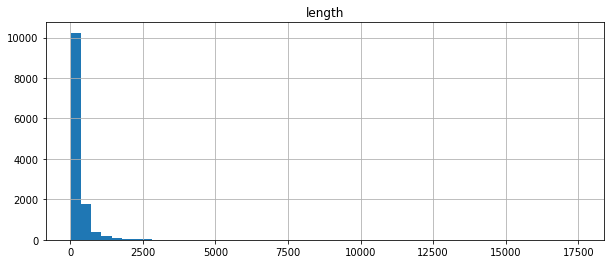

In [42]:
df.hist(bins=50,figsize=(10,4))

In [43]:
#max_length = 1000
max_length = 400
if long_doc:
    x_text = [x[:max_length] if len(x) > max_length else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe(percentiles=[0.5,0.75,0.8,0.9])

,length
count,12814.000000
mean,217.196348
std,117.936706
min,27.000000
50%,189.000000
75%,325.000000
80%,377.000000
90%,400.000000
max,400.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c260a4b70>]],
      dtype=object)

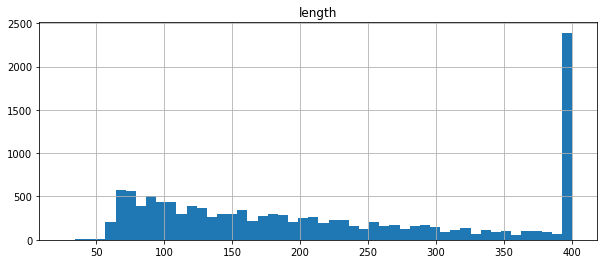

In [44]:
df.hist(bins=50,figsize=(10,4))

In [45]:
level = "char" #"word"

In [46]:
if level == "word":
    max_document_length = max([len(x.split(" ")) for x in x_text])
elif level == "char":
    max_document_length = max([len(x) for x in x_text])
print("max document length", max_document_length)

max document length 400


In [47]:
vocab_processor = preprocessing.VocabularyProcessor(max_document_length)

In [48]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

<IPython.core.display.Javascript object>

In [52]:
test_percentage = 0.1#0.0010 #0.1

In [53]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 2581
Train/Test split: 11533/1281


<IPython.core.display.Javascript object>

In [54]:
 y_test

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [55]:
print(x_train.shape)

(11533, 400)


In [56]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [57]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [73]:
embedding_size = 64     
filter_sizes = [2,3,4,5]    
num_filters=128               
dropout_keep_prob=0.3
l2_reg_lambda=0.2       

In [74]:
TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)

In [75]:
time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
prefix = ""
out_dir = os.path.join(os.path.curdir, "runs", time_path, prefix)
print("Writing to {}\n".format(out_dir))

Writing to ./runs/2018_06_30_22_36_44/



In [76]:
batch_size = 64                  
num_epochs = 200            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True

In [77]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    
    with sess.as_default():
        
        cnn = TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)


        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        test_summary_op = tf.summary.merge([loss_summary, acc_summary])
        test_summary_dir = os.path.join(out_dir, "summaries", "test")
        test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

        if save_checkpoint:
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
        vocab_processor.save(os.path.join(out_dir, "vocab"))


        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run([train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def test_step(x_batch, y_batch, writer=None):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            predictions, step, summaries, loss, accuracy = sess.run([cnn.predictions, global_step, test_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            print(len(np.where(predictions==1)[0]))
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                test_step(x_test, y_test, writer=test_summary_writer)
                print("")
                
            if save_checkpoint and current_step % evaluate_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/hist is illegal; using conv-maxpool-2/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/sparsity is illegal; using conv-maxpool-2/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/hist is illegal; using conv-maxpool-2/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/sparsity is illegal; using conv-maxpool-2/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/Variable:0/grad/hist is illegal; using conv-maxpool-2/Variable_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/Variable:0/grad/sparsity is illegal; using conv-maxpool-2/Variable_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/Vari

1281
2018-06-30T22:37:17.038257: step 40, loss 1.48115, acc 0.818891

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-40

2018-06-30T22:37:17.866165: step 41, loss 1.53912, acc 0.8125
2018-06-30T22:37:18.450842: step 42, loss 1.41338, acc 0.859375
2018-06-30T22:37:19.011296: step 43, loss 1.34912, acc 0.875
2018-06-30T22:37:19.603690: step 44, loss 1.43353, acc 0.78125
2018-06-30T22:37:20.221328: step 45, loss 1.42696, acc 0.78125
2018-06-30T22:37:20.773836: step 46, loss 1.28637, acc 0.859375
2018-06-30T22:37:21.360130: step 47, loss 1.43406, acc 0.71875
2018-06-30T22:37:21.962620: step 48, loss 1.28608, acc 0.8125
2018-06-30T22:37:22.523556: step 49, loss 1.19161, acc 0.875
2018-06-30T22:37:23.185894: step 50, loss 1.28676, acc 0.765625
2018-06-30T22:37:23.856801: step 51, loss 1.1143, acc 0.90625
2018-06-30T22:37:24.429249: step 52, loss 1.31895, acc 0.734375
2018-06-30T22:37:24.906223: step 53, loss 1.12106, acc 0.859375
20

2018-06-30T22:38:30.442505: step 151, loss 0.451511, acc 0.890625
2018-06-30T22:38:30.965245: step 152, loss 0.647538, acc 0.765625
2018-06-30T22:38:31.465697: step 153, loss 0.509975, acc 0.859375
2018-06-30T22:38:31.957557: step 154, loss 0.587927, acc 0.8125
2018-06-30T22:38:32.481815: step 155, loss 0.526609, acc 0.875
2018-06-30T22:38:33.001187: step 156, loss 0.417058, acc 0.890625
2018-06-30T22:38:33.506260: step 157, loss 0.552049, acc 0.828125
2018-06-30T22:38:33.988711: step 158, loss 0.464413, acc 0.875
2018-06-30T22:38:34.479547: step 159, loss 0.552635, acc 0.84375
2018-06-30T22:38:35.029845: step 160, loss 0.560041, acc 0.859375

Evaluation:
1281
2018-06-30T22:38:37.664458: step 160, loss 0.556907, acc 0.818891

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-160

2018-06-30T22:38:38.384640: step 161, loss 0.576861, acc 0.828125
2018-06-30T22:38:38.906723: step 162, loss 0.568516, acc 0.828125
2018-06-30T22:38:39.

2018-06-30T22:39:47.295950: step 261, loss 0.553917, acc 0.796875
2018-06-30T22:39:47.776785: step 262, loss 0.513443, acc 0.890625
2018-06-30T22:39:48.274853: step 263, loss 0.615267, acc 0.75
2018-06-30T22:39:48.751157: step 264, loss 0.478345, acc 0.875
2018-06-30T22:39:49.231635: step 265, loss 0.590846, acc 0.796875
2018-06-30T22:39:49.728167: step 266, loss 0.484189, acc 0.875
2018-06-30T22:39:50.202005: step 267, loss 0.613579, acc 0.78125
2018-06-30T22:39:50.673405: step 268, loss 0.49098, acc 0.859375
2018-06-30T22:39:51.179404: step 269, loss 0.535063, acc 0.84375
2018-06-30T22:39:51.701172: step 270, loss 0.528839, acc 0.828125
2018-06-30T22:39:52.189259: step 271, loss 0.619739, acc 0.78125
2018-06-30T22:39:52.700260: step 272, loss 0.659657, acc 0.75
2018-06-30T22:39:53.201207: step 273, loss 0.551116, acc 0.796875
2018-06-30T22:39:53.671394: step 274, loss 0.586656, acc 0.78125
2018-06-30T22:39:54.197732: step 275, loss 0.479941, acc 0.90625
2018-06-30T22:39:54.680326: st

2018-06-30T22:41:01.561678: step 373, loss 0.665303, acc 0.75
2018-06-30T22:41:02.034608: step 374, loss 0.48261, acc 0.859375
2018-06-30T22:41:02.491125: step 375, loss 0.509082, acc 0.84375
2018-06-30T22:41:02.952490: step 376, loss 0.55415, acc 0.84375
2018-06-30T22:41:03.430443: step 377, loss 0.600935, acc 0.78125
2018-06-30T22:41:03.903511: step 378, loss 0.492842, acc 0.875
2018-06-30T22:41:04.395653: step 379, loss 0.532077, acc 0.84375
2018-06-30T22:41:04.859390: step 380, loss 0.577994, acc 0.796875

Evaluation:
1281
2018-06-30T22:41:07.728594: step 380, loss 0.524542, acc 0.818891

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-380

2018-06-30T22:41:08.461007: step 381, loss 0.442915, acc 0.890625
2018-06-30T22:41:08.969952: step 382, loss 0.430048, acc 0.890625
2018-06-30T22:41:09.523628: step 383, loss 0.649156, acc 0.765625
2018-06-30T22:41:10.055530: step 384, loss 0.611181, acc 0.796875
2018-06-30T22:41:10.5577

2018-06-30T22:42:12.959926: step 481, loss 0.548933, acc 0.828125
2018-06-30T22:42:13.466435: step 482, loss 0.522102, acc 0.796875
2018-06-30T22:42:14.041749: step 483, loss 0.642241, acc 0.765625
2018-06-30T22:42:14.564112: step 484, loss 0.486691, acc 0.875
2018-06-30T22:42:15.105903: step 485, loss 0.616022, acc 0.796875
2018-06-30T22:42:15.669837: step 486, loss 0.558115, acc 0.828125
2018-06-30T22:42:16.226051: step 487, loss 0.505702, acc 0.828125
2018-06-30T22:42:16.749875: step 488, loss 0.555423, acc 0.8125
2018-06-30T22:42:17.298776: step 489, loss 0.707058, acc 0.734375
2018-06-30T22:42:17.811262: step 490, loss 0.481356, acc 0.875
2018-06-30T22:42:18.314129: step 491, loss 0.605601, acc 0.796875
2018-06-30T22:42:18.845707: step 492, loss 0.509176, acc 0.859375
2018-06-30T22:42:19.432521: step 493, loss 0.490919, acc 0.84375
2018-06-30T22:42:20.144816: step 494, loss 0.462764, acc 0.875
2018-06-30T22:42:20.670725: step 495, loss 0.477331, acc 0.859375
2018-06-30T22:42:21.24

2018-06-30T22:43:24.556868: step 592, loss 0.516518, acc 0.828125
2018-06-30T22:43:25.059749: step 593, loss 0.475111, acc 0.859375
2018-06-30T22:43:25.548178: step 594, loss 0.585671, acc 0.828125
2018-06-30T22:43:26.075716: step 595, loss 0.536057, acc 0.8125
2018-06-30T22:43:26.567159: step 596, loss 0.417053, acc 0.875
2018-06-30T22:43:27.105459: step 597, loss 0.538017, acc 0.828125
2018-06-30T22:43:27.689662: step 598, loss 0.622166, acc 0.8125
2018-06-30T22:43:28.299790: step 599, loss 0.725499, acc 0.75
2018-06-30T22:43:28.987497: step 600, loss 0.574125, acc 0.828125

Evaluation:
1281
2018-06-30T22:43:31.902633: step 600, loss 0.542219, acc 0.818891

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-600

2018-06-30T22:43:32.665059: step 601, loss 0.534945, acc 0.828125
2018-06-30T22:43:33.217431: step 602, loss 0.54262, acc 0.828125
2018-06-30T22:43:33.823368: step 603, loss 0.572056, acc 0.796875
2018-06-30T22:43:34.383

2018-06-30T22:45:00.865470: step 701, loss 0.481321, acc 0.875
2018-06-30T22:45:01.436765: step 702, loss 0.515378, acc 0.796875
2018-06-30T22:45:02.001135: step 703, loss 0.463553, acc 0.84375
2018-06-30T22:45:02.568664: step 704, loss 0.670967, acc 0.78125
2018-06-30T22:45:03.115492: step 705, loss 0.615918, acc 0.8125
2018-06-30T22:45:03.726431: step 706, loss 0.67359, acc 0.75
2018-06-30T22:45:04.343875: step 707, loss 0.533425, acc 0.828125
2018-06-30T22:45:04.970126: step 708, loss 0.593865, acc 0.8125
2018-06-30T22:45:05.651429: step 709, loss 0.542321, acc 0.8125
2018-06-30T22:45:06.273617: step 710, loss 0.590223, acc 0.78125
2018-06-30T22:45:06.820568: step 711, loss 0.54604, acc 0.828125
2018-06-30T22:45:07.399067: step 712, loss 0.475295, acc 0.875
2018-06-30T22:45:07.966723: step 713, loss 0.552626, acc 0.828125
2018-06-30T22:45:08.514240: step 714, loss 0.413817, acc 0.875
2018-06-30T22:45:09.071179: step 715, loss 0.326239, acc 0.90625
2018-06-30T22:45:09.630805: step 71

2018-06-30T22:46:18.432468: step 813, loss 0.51653, acc 0.84375
2018-06-30T22:46:18.951334: step 814, loss 0.516864, acc 0.8125
2018-06-30T22:46:19.554306: step 815, loss 0.473716, acc 0.859375
2018-06-30T22:46:20.169760: step 816, loss 0.483474, acc 0.84375
2018-06-30T22:46:20.674688: step 817, loss 0.524608, acc 0.828125
2018-06-30T22:46:21.207613: step 818, loss 0.585398, acc 0.765625
2018-06-30T22:46:21.782035: step 819, loss 0.515264, acc 0.84375
2018-06-30T22:46:22.324980: step 820, loss 0.44644, acc 0.875

Evaluation:
1281
2018-06-30T22:46:25.136093: step 820, loss 0.514717, acc 0.818891

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-820

2018-06-30T22:46:25.854840: step 821, loss 0.563941, acc 0.8125
2018-06-30T22:46:26.329568: step 822, loss 0.460815, acc 0.859375
2018-06-30T22:46:26.820079: step 823, loss 0.475357, acc 0.859375
2018-06-30T22:46:27.306688: step 824, loss 0.570483, acc 0.828125
2018-06-30T22:46:27.795

2018-06-30T22:47:33.995963: step 922, loss 0.578267, acc 0.765625
2018-06-30T22:47:34.502114: step 923, loss 0.491804, acc 0.875
2018-06-30T22:47:35.028733: step 924, loss 0.527228, acc 0.828125
2018-06-30T22:47:35.548866: step 925, loss 0.539371, acc 0.8125
2018-06-30T22:47:36.102004: step 926, loss 0.480052, acc 0.828125
2018-06-30T22:47:36.667461: step 927, loss 0.494017, acc 0.875
2018-06-30T22:47:37.206126: step 928, loss 0.487071, acc 0.84375
2018-06-30T22:47:37.736453: step 929, loss 0.585457, acc 0.8125
2018-06-30T22:47:38.278254: step 930, loss 0.683066, acc 0.78125
2018-06-30T22:47:38.806164: step 931, loss 0.45001, acc 0.859375
2018-06-30T22:47:39.407016: step 932, loss 0.570802, acc 0.78125
2018-06-30T22:47:39.946067: step 933, loss 0.616966, acc 0.71875
2018-06-30T22:47:40.495056: step 934, loss 0.537405, acc 0.84375
2018-06-30T22:47:41.029767: step 935, loss 0.554018, acc 0.828125
2018-06-30T22:47:41.518801: step 936, loss 0.513323, acc 0.828125
2018-06-30T22:47:42.017092

2018-06-30T22:48:46.506686: step 1033, loss 0.510048, acc 0.84375
2018-06-30T22:48:47.068136: step 1034, loss 0.55627, acc 0.765625
2018-06-30T22:48:47.618151: step 1035, loss 0.401656, acc 0.875
2018-06-30T22:48:48.169030: step 1036, loss 0.530853, acc 0.828125
2018-06-30T22:48:48.674776: step 1037, loss 0.445525, acc 0.859375
2018-06-30T22:48:49.221848: step 1038, loss 0.419956, acc 0.859375
2018-06-30T22:48:49.799269: step 1039, loss 0.486958, acc 0.859375
2018-06-30T22:48:50.333304: step 1040, loss 0.463827, acc 0.828125

Evaluation:
1281
2018-06-30T22:48:53.478790: step 1040, loss 0.512794, acc 0.818891

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-1040

2018-06-30T22:48:54.261334: step 1041, loss 0.460742, acc 0.859375
2018-06-30T22:48:54.833746: step 1042, loss 0.454201, acc 0.828125
2018-06-30T22:48:55.387792: step 1043, loss 0.370021, acc 0.921875
2018-06-30T22:48:55.920858: step 1044, loss 0.517622, acc 0.8125
2018

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-1140

2018-06-30T22:50:16.218668: step 1141, loss 0.580842, acc 0.78125
2018-06-30T22:50:16.746475: step 1142, loss 0.557031, acc 0.78125
2018-06-30T22:50:17.295629: step 1143, loss 0.501769, acc 0.8125
2018-06-30T22:50:17.841485: step 1144, loss 0.527151, acc 0.828125
2018-06-30T22:50:18.383211: step 1145, loss 0.606423, acc 0.734375
2018-06-30T22:50:18.913464: step 1146, loss 0.588007, acc 0.734375
2018-06-30T22:50:19.488813: step 1147, loss 0.479203, acc 0.859375
2018-06-30T22:50:20.106962: step 1148, loss 0.516763, acc 0.8125
2018-06-30T22:50:20.660979: step 1149, loss 0.548159, acc 0.75
2018-06-30T22:50:21.217002: step 1150, loss 0.451842, acc 0.84375
2018-06-30T22:50:21.761955: step 1151, loss 0.469696, acc 0.859375
2018-06-30T22:50:22.324515: step 1152, loss 0.590058, acc 0.78125
2018-06-30T22:50:22.878370: step 1153, loss 0.559058, acc 0.796875
2018-06-30T22:50:23.442268: 

2018-06-30T22:51:27.809293: step 1249, loss 0.543099, acc 0.796875
2018-06-30T22:51:28.361888: step 1250, loss 0.533132, acc 0.765625
2018-06-30T22:51:28.858631: step 1251, loss 0.409074, acc 0.890625
2018-06-30T22:51:29.360438: step 1252, loss 0.469972, acc 0.84375
2018-06-30T22:51:29.813928: step 1253, loss 0.417901, acc 0.84375
2018-06-30T22:51:30.285539: step 1254, loss 0.484173, acc 0.859375
2018-06-30T22:51:30.767336: step 1255, loss 0.694638, acc 0.734375
2018-06-30T22:51:31.260700: step 1256, loss 0.48238, acc 0.8125
2018-06-30T22:51:31.794172: step 1257, loss 0.517047, acc 0.796875
2018-06-30T22:51:32.298597: step 1258, loss 0.466521, acc 0.84375
2018-06-30T22:51:32.792259: step 1259, loss 0.476621, acc 0.859375
2018-06-30T22:51:33.315896: step 1260, loss 0.627519, acc 0.6875

Evaluation:
1281
2018-06-30T22:51:35.985295: step 1260, loss 0.502753, acc 0.818891

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-1260

2018-

2018-06-30T22:52:37.075827: step 1359, loss 0.492775, acc 0.796875
2018-06-30T22:52:37.580477: step 1360, loss 0.546112, acc 0.75

Evaluation:
1281
2018-06-30T22:52:40.318272: step 1360, loss 0.48937, acc 0.818891

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-1360

2018-06-30T22:52:41.079087: step 1361, loss 0.380679, acc 0.875
2018-06-30T22:52:41.644067: step 1362, loss 0.467216, acc 0.796875
2018-06-30T22:52:42.169626: step 1363, loss 0.415386, acc 0.859375
2018-06-30T22:52:42.714009: step 1364, loss 0.536453, acc 0.796875
2018-06-30T22:52:43.266286: step 1365, loss 0.496436, acc 0.828125
2018-06-30T22:52:43.774805: step 1366, loss 0.421934, acc 0.875
2018-06-30T22:52:44.310325: step 1367, loss 0.401059, acc 0.828125
2018-06-30T22:52:44.890909: step 1368, loss 0.519058, acc 0.765625
2018-06-30T22:52:45.492357: step 1369, loss 0.395661, acc 0.875
2018-06-30T22:52:46.122564: step 1370, loss 0.471454, acc 0.8125
2018-06-30T22

2018-06-30T22:53:57.501006: step 1466, loss 0.45775, acc 0.875
2018-06-30T22:53:58.065883: step 1467, loss 0.458242, acc 0.84375
2018-06-30T22:53:58.706727: step 1468, loss 0.468665, acc 0.8125
2018-06-30T22:53:59.362834: step 1469, loss 0.514318, acc 0.828125
2018-06-30T22:54:00.026873: step 1470, loss 0.451613, acc 0.796875
2018-06-30T22:54:00.647171: step 1471, loss 0.453552, acc 0.828125
2018-06-30T22:54:01.348832: step 1472, loss 0.546322, acc 0.796875
2018-06-30T22:54:02.069616: step 1473, loss 0.423096, acc 0.859375
2018-06-30T22:54:02.696285: step 1474, loss 0.547535, acc 0.75
2018-06-30T22:54:03.284036: step 1475, loss 0.472037, acc 0.78125
2018-06-30T22:54:03.878355: step 1476, loss 0.488454, acc 0.796875
2018-06-30T22:54:04.443322: step 1477, loss 0.507768, acc 0.796875
2018-06-30T22:54:05.021940: step 1478, loss 0.534174, acc 0.796875
2018-06-30T22:54:05.619053: step 1479, loss 0.41354, acc 0.875
2018-06-30T22:54:06.196085: step 1480, loss 0.487232, acc 0.8125

Evaluation:


2018-06-30T22:55:25.085429: step 1576, loss 0.580761, acc 0.78125
2018-06-30T22:55:25.573473: step 1577, loss 0.450075, acc 0.890625
2018-06-30T22:55:26.068841: step 1578, loss 0.576737, acc 0.75
2018-06-30T22:55:26.535844: step 1579, loss 0.468482, acc 0.828125
2018-06-30T22:55:27.022748: step 1580, loss 0.56112, acc 0.75

Evaluation:
1281
2018-06-30T22:55:29.984095: step 1580, loss 0.493131, acc 0.818891

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-1580

2018-06-30T22:55:30.715361: step 1581, loss 0.462873, acc 0.8125
2018-06-30T22:55:31.277158: step 1582, loss 0.470206, acc 0.8125
2018-06-30T22:55:31.787188: step 1583, loss 0.394312, acc 0.9375
2018-06-30T22:55:32.289804: step 1584, loss 0.341773, acc 0.875
2018-06-30T22:55:32.769629: step 1585, loss 0.561288, acc 0.8125
2018-06-30T22:55:33.271520: step 1586, loss 0.464621, acc 0.828125
2018-06-30T22:55:33.755170: step 1587, loss 0.43019, acc 0.84375
2018-06-30T22:55:34.

2018-06-30T22:56:35.126435: step 1683, loss 0.356997, acc 0.90625
2018-06-30T22:56:35.620571: step 1684, loss 0.445096, acc 0.84375
2018-06-30T22:56:36.156226: step 1685, loss 0.513644, acc 0.8125
2018-06-30T22:56:36.586140: step 1686, loss 0.496358, acc 0.84375
2018-06-30T22:56:37.109772: step 1687, loss 0.368604, acc 0.890625
2018-06-30T22:56:37.601796: step 1688, loss 0.358205, acc 0.875
2018-06-30T22:56:38.091872: step 1689, loss 0.398906, acc 0.875
2018-06-30T22:56:38.581279: step 1690, loss 0.458599, acc 0.859375
2018-06-30T22:56:39.055907: step 1691, loss 0.461589, acc 0.8125
2018-06-30T22:56:39.553422: step 1692, loss 0.559868, acc 0.765625
2018-06-30T22:56:40.050938: step 1693, loss 0.395449, acc 0.84375
2018-06-30T22:56:40.527719: step 1694, loss 0.419432, acc 0.796875
2018-06-30T22:56:41.001152: step 1695, loss 0.381664, acc 0.875
2018-06-30T22:56:41.481973: step 1696, loss 0.430318, acc 0.828125
2018-06-30T22:56:41.953931: step 1697, loss 0.432819, acc 0.8125
2018-06-30T22:

2018-06-30T22:57:42.018352: step 1793, loss 0.482723, acc 0.875
2018-06-30T22:57:42.512318: step 1794, loss 0.474959, acc 0.828125
2018-06-30T22:57:43.036120: step 1795, loss 0.485074, acc 0.78125
2018-06-30T22:57:43.539147: step 1796, loss 0.445058, acc 0.828125
2018-06-30T22:57:44.082109: step 1797, loss 0.351479, acc 0.859375
2018-06-30T22:57:44.629911: step 1798, loss 0.374605, acc 0.90625
2018-06-30T22:57:45.105678: step 1799, loss 0.470455, acc 0.8125
2018-06-30T22:57:45.550998: step 1800, loss 0.486069, acc 0.84375

Evaluation:
1281
2018-06-30T22:57:48.013605: step 1800, loss 0.481066, acc 0.818891

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-1800

2018-06-30T22:57:48.684762: step 1801, loss 0.374298, acc 0.84375
2018-06-30T22:57:49.190883: step 1802, loss 0.524232, acc 0.765625
2018-06-30T22:57:49.709243: step 1803, loss 0.513599, acc 0.8125
2018-06-30T22:57:50.278294: step 1804, loss 0.401832, acc 0.828125
2018-06-

2018-06-30T22:58:52.502041: step 1901, loss 0.416687, acc 0.828125
2018-06-30T22:58:52.990902: step 1902, loss 0.535942, acc 0.78125
2018-06-30T22:58:53.484231: step 1903, loss 0.418654, acc 0.828125
2018-06-30T22:58:54.049674: step 1904, loss 0.455695, acc 0.828125
2018-06-30T22:58:54.558319: step 1905, loss 0.561795, acc 0.78125
2018-06-30T22:58:55.087526: step 1906, loss 0.450476, acc 0.828125
2018-06-30T22:58:55.570492: step 1907, loss 0.435353, acc 0.78125
2018-06-30T22:58:56.096873: step 1908, loss 0.438357, acc 0.78125
2018-06-30T22:58:56.575998: step 1909, loss 0.435802, acc 0.765625
2018-06-30T22:58:57.058581: step 1910, loss 0.412903, acc 0.8125
2018-06-30T22:58:57.585196: step 1911, loss 0.414896, acc 0.859375
2018-06-30T22:58:58.118011: step 1912, loss 0.445316, acc 0.859375
2018-06-30T22:58:58.616309: step 1913, loss 0.411957, acc 0.84375
2018-06-30T22:58:59.147342: step 1914, loss 0.394457, acc 0.875
2018-06-30T22:58:59.739429: step 1915, loss 0.4888, acc 0.828125
2018-06

2018-06-30T23:00:01.754531: step 2011, loss 0.620939, acc 0.75
2018-06-30T23:00:02.208639: step 2012, loss 0.486835, acc 0.765625
2018-06-30T23:00:02.696141: step 2013, loss 0.574733, acc 0.75
2018-06-30T23:00:03.165172: step 2014, loss 0.548839, acc 0.765625
2018-06-30T23:00:03.670507: step 2015, loss 0.432079, acc 0.890625
2018-06-30T23:00:04.166752: step 2016, loss 0.440935, acc 0.859375
2018-06-30T23:00:04.595178: step 2017, loss 0.578288, acc 0.703125
2018-06-30T23:00:05.055639: step 2018, loss 0.54364, acc 0.796875
2018-06-30T23:00:05.532994: step 2019, loss 0.427369, acc 0.84375
2018-06-30T23:00:06.050740: step 2020, loss 0.510849, acc 0.8125

Evaluation:
1272
2018-06-30T23:00:08.791479: step 2020, loss 0.481983, acc 0.821233

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-2020

2018-06-30T23:00:09.489947: step 2021, loss 0.453515, acc 0.796875
2018-06-30T23:00:10.096623: step 2022, loss 0.364872, acc 0.875
2018-06-30T2

2018-06-30T23:01:13.085841: step 2120, loss 0.375465, acc 0.890625

Evaluation:
1275
2018-06-30T23:01:16.642703: step 2120, loss 0.492662, acc 0.820453

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-2120

2018-06-30T23:01:17.394669: step 2121, loss 0.481831, acc 0.8125
2018-06-30T23:01:17.921859: step 2122, loss 0.567344, acc 0.75
2018-06-30T23:01:18.437561: step 2123, loss 0.377571, acc 0.875
2018-06-30T23:01:18.943910: step 2124, loss 0.471453, acc 0.84375
2018-06-30T23:01:19.552924: step 2125, loss 0.469425, acc 0.828125
2018-06-30T23:01:20.203544: step 2126, loss 0.518163, acc 0.859375
2018-06-30T23:01:20.718356: step 2127, loss 0.454598, acc 0.859375
2018-06-30T23:01:21.255407: step 2128, loss 0.392346, acc 0.859375
2018-06-30T23:01:21.788143: step 2129, loss 0.36798, acc 0.796875
2018-06-30T23:01:22.339863: step 2130, loss 0.464872, acc 0.8125
2018-06-30T23:01:22.822753: step 2131, loss 0.361405, acc 0.84375
2018-06-30T

2018-06-30T23:02:23.731821: step 2227, loss 0.374158, acc 0.921875
2018-06-30T23:02:24.221713: step 2228, loss 0.455405, acc 0.8125
2018-06-30T23:02:24.672751: step 2229, loss 0.44062, acc 0.8125
2018-06-30T23:02:25.126529: step 2230, loss 0.431266, acc 0.8125
2018-06-30T23:02:25.587541: step 2231, loss 0.457627, acc 0.859375
2018-06-30T23:02:26.057464: step 2232, loss 0.36786, acc 0.859375
2018-06-30T23:02:26.528752: step 2233, loss 0.448276, acc 0.78125
2018-06-30T23:02:26.979005: step 2234, loss 0.462954, acc 0.78125
2018-06-30T23:02:27.462548: step 2235, loss 0.413375, acc 0.8125
2018-06-30T23:02:27.943591: step 2236, loss 0.400308, acc 0.8125
2018-06-30T23:02:28.403221: step 2237, loss 0.551656, acc 0.765625
2018-06-30T23:02:28.875049: step 2238, loss 0.466747, acc 0.84375
2018-06-30T23:02:29.369166: step 2239, loss 0.395991, acc 0.875
2018-06-30T23:02:29.827852: step 2240, loss 0.469974, acc 0.875

Evaluation:
1229
2018-06-30T23:02:32.498955: step 2240, loss 0.471809, acc 0.83450

2018-06-30T23:03:29.860815: step 2337, loss 0.393195, acc 0.875
2018-06-30T23:03:30.310120: step 2338, loss 0.522105, acc 0.78125
2018-06-30T23:03:30.777974: step 2339, loss 0.357593, acc 0.890625
2018-06-30T23:03:31.255611: step 2340, loss 0.457309, acc 0.796875

Evaluation:
1263
2018-06-30T23:03:34.090595: step 2340, loss 0.471038, acc 0.826698

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-2340

2018-06-30T23:03:34.720431: step 2341, loss 0.318974, acc 0.90625
2018-06-30T23:03:35.186523: step 2342, loss 0.371786, acc 0.875
2018-06-30T23:03:35.634107: step 2343, loss 0.609514, acc 0.734375
2018-06-30T23:03:36.107172: step 2344, loss 0.297898, acc 0.921875
2018-06-30T23:03:36.571685: step 2345, loss 0.525278, acc 0.78125
2018-06-30T23:03:37.049752: step 2346, loss 0.341559, acc 0.890625
2018-06-30T23:03:37.530242: step 2347, loss 0.407181, acc 0.828125
2018-06-30T23:03:37.995737: step 2348, loss 0.422606, acc 0.828125
2018-0

2018-06-30T23:04:47.004143: step 2443, loss 0.455102, acc 0.828125
2018-06-30T23:04:47.571265: step 2444, loss 0.33004, acc 0.875
2018-06-30T23:04:48.176494: step 2445, loss 0.627853, acc 0.734375
2018-06-30T23:04:48.740935: step 2446, loss 0.451453, acc 0.859375
2018-06-30T23:04:49.382572: step 2447, loss 0.374636, acc 0.953125
2018-06-30T23:04:49.964061: step 2448, loss 0.417408, acc 0.875
2018-06-30T23:04:50.482308: step 2449, loss 0.355169, acc 0.890625
2018-06-30T23:04:51.052882: step 2450, loss 0.372048, acc 0.9375
2018-06-30T23:04:51.552044: step 2451, loss 0.309108, acc 0.921875
2018-06-30T23:04:52.122543: step 2452, loss 0.34621, acc 0.90625
2018-06-30T23:04:52.690845: step 2453, loss 0.490665, acc 0.828125
2018-06-30T23:04:53.259286: step 2454, loss 0.484947, acc 0.75
2018-06-30T23:04:53.766010: step 2455, loss 0.440807, acc 0.78125
2018-06-30T23:04:54.289269: step 2456, loss 0.319443, acc 0.859375
2018-06-30T23:04:54.845563: step 2457, loss 0.323306, acc 0.9375
2018-06-30T23

2018-06-30T23:06:03.983698: step 2552, loss 0.442847, acc 0.859375
2018-06-30T23:06:04.537891: step 2553, loss 0.474719, acc 0.84375
2018-06-30T23:06:05.104278: step 2554, loss 0.434017, acc 0.875
2018-06-30T23:06:05.696429: step 2555, loss 0.486977, acc 0.8125
2018-06-30T23:06:06.248935: step 2556, loss 0.361722, acc 0.890625
2018-06-30T23:06:06.759616: step 2557, loss 0.363659, acc 0.890625
2018-06-30T23:06:07.262681: step 2558, loss 0.398016, acc 0.84375
2018-06-30T23:06:07.847241: step 2559, loss 0.369397, acc 0.921875
2018-06-30T23:06:08.388545: step 2560, loss 0.482674, acc 0.765625

Evaluation:
1254
2018-06-30T23:06:11.317348: step 2560, loss 0.472609, acc 0.832162

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-2560

2018-06-30T23:06:12.105938: step 2561, loss 0.305805, acc 0.90625
2018-06-30T23:06:12.609670: step 2562, loss 0.326159, acc 0.875
2018-06-30T23:06:13.195124: step 2563, loss 0.328138, acc 0.859375
2018-06-

1212
2018-06-30T23:07:22.589109: step 2660, loss 0.470578, acc 0.836846

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-2660

2018-06-30T23:07:23.293134: step 2661, loss 0.464368, acc 0.84375
2018-06-30T23:07:23.765344: step 2662, loss 0.415399, acc 0.890625
2018-06-30T23:07:24.256889: step 2663, loss 0.481307, acc 0.859375
2018-06-30T23:07:24.754916: step 2664, loss 0.376474, acc 0.875
2018-06-30T23:07:25.261032: step 2665, loss 0.393169, acc 0.859375
2018-06-30T23:07:25.737953: step 2666, loss 0.449483, acc 0.84375
2018-06-30T23:07:26.236079: step 2667, loss 0.306082, acc 0.96875
2018-06-30T23:07:26.794104: step 2668, loss 0.438257, acc 0.84375
2018-06-30T23:07:27.410144: step 2669, loss 0.290958, acc 0.90625
2018-06-30T23:07:27.984239: step 2670, loss 0.415267, acc 0.828125
2018-06-30T23:07:28.510489: step 2671, loss 0.370892, acc 0.859375
2018-06-30T23:07:29.037958: step 2672, loss 0.295029, acc 0.890625
2018-06-30T23:07:2

2018-06-30T23:08:34.024265: step 2768, loss 0.437549, acc 0.890625
2018-06-30T23:08:34.554072: step 2769, loss 0.427769, acc 0.8125
2018-06-30T23:08:35.138186: step 2770, loss 0.46489, acc 0.84375
2018-06-30T23:08:35.667752: step 2771, loss 0.369678, acc 0.90625
2018-06-30T23:08:36.195090: step 2772, loss 0.383406, acc 0.875
2018-06-30T23:08:36.706195: step 2773, loss 0.430968, acc 0.875
2018-06-30T23:08:37.217504: step 2774, loss 0.353019, acc 0.890625
2018-06-30T23:08:37.749473: step 2775, loss 0.350035, acc 0.890625
2018-06-30T23:08:38.304725: step 2776, loss 0.382715, acc 0.875
2018-06-30T23:08:38.822731: step 2777, loss 0.489131, acc 0.78125
2018-06-30T23:08:39.341439: step 2778, loss 0.360734, acc 0.875
2018-06-30T23:08:39.857266: step 2779, loss 0.312149, acc 0.9375
2018-06-30T23:08:40.378572: step 2780, loss 0.371122, acc 0.84375

Evaluation:
1220
2018-06-30T23:08:43.863287: step 2780, loss 0.48848, acc 0.835285

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/r

2018-06-30T23:09:49.444064: step 2877, loss 0.452129, acc 0.796875
2018-06-30T23:09:49.921677: step 2878, loss 0.478714, acc 0.84375
2018-06-30T23:09:50.404771: step 2879, loss 0.476264, acc 0.765625
2018-06-30T23:09:50.967044: step 2880, loss 0.351692, acc 0.890625

Evaluation:
1257
2018-06-30T23:09:54.006904: step 2880, loss 0.488805, acc 0.82982

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-2880

2018-06-30T23:09:54.722595: step 2881, loss 0.337167, acc 0.90625
2018-06-30T23:09:55.235927: step 2882, loss 0.396761, acc 0.84375
2018-06-30T23:09:55.745711: step 2883, loss 0.312224, acc 0.921875
2018-06-30T23:09:56.267751: step 2884, loss 0.321626, acc 0.875
2018-06-30T23:09:56.773969: step 2885, loss 0.3703, acc 0.90625
2018-06-30T23:09:57.275143: step 2886, loss 0.348659, acc 0.890625
2018-06-30T23:09:57.776825: step 2887, loss 0.435577, acc 0.859375
2018-06-30T23:09:58.267891: step 2888, loss 0.391972, acc 0.859375
2018-06

2018-06-30T23:11:08.240020: step 2984, loss 0.413239, acc 0.828125
2018-06-30T23:11:08.782074: step 2985, loss 0.437946, acc 0.8125
2018-06-30T23:11:09.326616: step 2986, loss 0.346696, acc 0.90625
2018-06-30T23:11:09.889696: step 2987, loss 0.418705, acc 0.859375
2018-06-30T23:11:10.430113: step 2988, loss 0.400761, acc 0.84375
2018-06-30T23:11:10.936797: step 2989, loss 0.378997, acc 0.921875
2018-06-30T23:11:11.444449: step 2990, loss 0.436412, acc 0.796875
2018-06-30T23:11:11.966988: step 2991, loss 0.380214, acc 0.9375
2018-06-30T23:11:12.456949: step 2992, loss 0.46561, acc 0.859375
2018-06-30T23:11:12.979502: step 2993, loss 0.333766, acc 0.9375
2018-06-30T23:11:13.531189: step 2994, loss 0.301697, acc 0.921875
2018-06-30T23:11:14.072722: step 2995, loss 0.291797, acc 0.9375
2018-06-30T23:11:14.600571: step 2996, loss 0.403563, acc 0.796875
2018-06-30T23:11:15.135150: step 2997, loss 0.532672, acc 0.84375
2018-06-30T23:11:15.712084: step 2998, loss 0.362829, acc 0.875
2018-06-30

2018-06-30T23:12:21.241177: step 3093, loss 0.421901, acc 0.859375
2018-06-30T23:12:21.750401: step 3094, loss 0.443235, acc 0.890625
2018-06-30T23:12:22.248414: step 3095, loss 0.3777, acc 0.875
2018-06-30T23:12:22.730276: step 3096, loss 0.396032, acc 0.859375
2018-06-30T23:12:23.225844: step 3097, loss 0.408332, acc 0.9375
2018-06-30T23:12:23.725007: step 3098, loss 0.357687, acc 0.890625
2018-06-30T23:12:24.272046: step 3099, loss 0.439316, acc 0.875
2018-06-30T23:12:24.751841: step 3100, loss 0.377612, acc 0.890625

Evaluation:
1263
2018-06-30T23:12:27.470591: step 3100, loss 0.504597, acc 0.825137

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-3100

2018-06-30T23:12:28.159423: step 3101, loss 0.50813, acc 0.8125
2018-06-30T23:12:28.677886: step 3102, loss 0.466869, acc 0.78125
2018-06-30T23:12:29.164422: step 3103, loss 0.345905, acc 0.921875
2018-06-30T23:12:29.669629: step 3104, loss 0.427142, acc 0.875
2018-06-30T23:

2018-06-30T23:13:37.104387: step 3201, loss 0.382644, acc 0.90625
2018-06-30T23:13:37.564642: step 3202, loss 0.387569, acc 0.859375
2018-06-30T23:13:38.047417: step 3203, loss 0.376726, acc 0.859375
2018-06-30T23:13:38.531671: step 3204, loss 0.429595, acc 0.796875
2018-06-30T23:13:39.041964: step 3205, loss 0.392406, acc 0.8125
2018-06-30T23:13:39.573244: step 3206, loss 0.520618, acc 0.796875
2018-06-30T23:13:40.092215: step 3207, loss 0.388415, acc 0.890625
2018-06-30T23:13:40.589413: step 3208, loss 0.338923, acc 0.9375
2018-06-30T23:13:41.120547: step 3209, loss 0.356456, acc 0.90625
2018-06-30T23:13:41.637673: step 3210, loss 0.347225, acc 0.875
2018-06-30T23:13:42.188483: step 3211, loss 0.315641, acc 0.921875
2018-06-30T23:13:42.763157: step 3212, loss 0.383193, acc 0.890625
2018-06-30T23:13:43.392293: step 3213, loss 0.433483, acc 0.859375
2018-06-30T23:13:43.982040: step 3214, loss 0.3732, acc 0.875
2018-06-30T23:13:44.584322: step 3215, loss 0.392018, acc 0.90625
2018-06-30

2018-06-30T23:14:46.793322: step 3310, loss 0.306874, acc 0.921875
2018-06-30T23:14:47.283267: step 3311, loss 0.496437, acc 0.75
2018-06-30T23:14:47.769657: step 3312, loss 0.475001, acc 0.828125
2018-06-30T23:14:48.257337: step 3313, loss 0.396286, acc 0.90625
2018-06-30T23:14:48.732911: step 3314, loss 0.491716, acc 0.875
2018-06-30T23:14:49.207785: step 3315, loss 0.421424, acc 0.890625
2018-06-30T23:14:49.729199: step 3316, loss 0.376486, acc 0.953125
2018-06-30T23:14:50.218347: step 3317, loss 0.401934, acc 0.875
2018-06-30T23:14:50.685138: step 3318, loss 0.41971, acc 0.890625
2018-06-30T23:14:51.206519: step 3319, loss 0.385653, acc 0.890625
2018-06-30T23:14:51.742896: step 3320, loss 0.385226, acc 0.84375

Evaluation:
1239
2018-06-30T23:14:54.513079: step 3320, loss 0.483864, acc 0.832943

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-3320

2018-06-30T23:14:55.303151: step 3321, loss 0.387157, acc 0.84375
2018-06-30T

2018-06-30T23:16:01.850506: step 3419, loss 0.367948, acc 0.90625
2018-06-30T23:16:02.382016: step 3420, loss 0.453988, acc 0.859375

Evaluation:
1178
2018-06-30T23:16:05.429826: step 3420, loss 0.477924, acc 0.847775

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-3420

2018-06-30T23:16:06.177485: step 3421, loss 0.342081, acc 0.90625
2018-06-30T23:16:06.674331: step 3422, loss 0.402038, acc 0.921875
2018-06-30T23:16:07.183954: step 3423, loss 0.425903, acc 0.859375
2018-06-30T23:16:07.677424: step 3424, loss 0.476697, acc 0.828125
2018-06-30T23:16:08.150724: step 3425, loss 0.375502, acc 0.921875
2018-06-30T23:16:08.665285: step 3426, loss 0.442581, acc 0.859375
2018-06-30T23:16:09.187238: step 3427, loss 0.346255, acc 0.90625
2018-06-30T23:16:09.688494: step 3428, loss 0.469995, acc 0.84375
2018-06-30T23:16:10.159353: step 3429, loss 0.544947, acc 0.859375
2018-06-30T23:16:10.633809: step 3430, loss 0.375098, acc 0.90625
20

2018-06-30T23:17:29.011510: step 3526, loss 0.296367, acc 0.9375
2018-06-30T23:17:29.695760: step 3527, loss 0.330064, acc 0.90625
2018-06-30T23:17:30.395403: step 3528, loss 0.405825, acc 0.859375
2018-06-30T23:17:31.067762: step 3529, loss 0.491723, acc 0.84375
2018-06-30T23:17:31.763648: step 3530, loss 0.365024, acc 0.890625
2018-06-30T23:17:32.430393: step 3531, loss 0.44076, acc 0.875
2018-06-30T23:17:33.150768: step 3532, loss 0.380133, acc 0.890625
2018-06-30T23:17:33.841968: step 3533, loss 0.477291, acc 0.875
2018-06-30T23:17:34.538987: step 3534, loss 0.370639, acc 0.9375
2018-06-30T23:17:35.253191: step 3535, loss 0.37201, acc 0.9375
2018-06-30T23:17:35.960155: step 3536, loss 0.430617, acc 0.859375
2018-06-30T23:17:36.677987: step 3537, loss 0.379434, acc 0.90625
2018-06-30T23:17:37.355295: step 3538, loss 0.423244, acc 0.84375
2018-06-30T23:17:38.025894: step 3539, loss 0.379017, acc 0.875
2018-06-30T23:17:38.683108: step 3540, loss 0.488667, acc 0.8125

Evaluation:
1245


2018-06-30T23:19:00.067755: step 3636, loss 0.381767, acc 0.875
2018-06-30T23:19:00.630961: step 3637, loss 0.509395, acc 0.84375
2018-06-30T23:19:01.201466: step 3638, loss 0.443892, acc 0.890625
2018-06-30T23:19:01.747914: step 3639, loss 0.397087, acc 0.890625
2018-06-30T23:19:02.325405: step 3640, loss 0.272147, acc 0.953125

Evaluation:
1201
2018-06-30T23:19:06.323529: step 3640, loss 0.471642, acc 0.840749

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-3640

2018-06-30T23:19:07.171502: step 3641, loss 0.337507, acc 0.953125
2018-06-30T23:19:07.836611: step 3642, loss 0.392413, acc 0.859375
2018-06-30T23:19:08.508910: step 3643, loss 0.324441, acc 0.90625
2018-06-30T23:19:09.074472: step 3644, loss 0.356378, acc 0.84375
2018-06-30T23:19:09.656195: step 3645, loss 0.335737, acc 0.9375
2018-06-30T23:19:10.267918: step 3646, loss 0.371472, acc 0.84375
2018-06-30T23:19:10.863979: step 3647, loss 0.472703, acc 0.84375
2018-06

2018-06-30T23:20:35.770549: step 3742, loss 0.453277, acc 0.859375
2018-06-30T23:20:36.546625: step 3743, loss 0.345693, acc 0.890625
2018-06-30T23:20:37.175920: step 3744, loss 0.363147, acc 0.890625
2018-06-30T23:20:37.759660: step 3745, loss 0.33601, acc 0.921875
2018-06-30T23:20:38.363073: step 3746, loss 0.42973, acc 0.859375
2018-06-30T23:20:38.958023: step 3747, loss 0.305959, acc 0.9375
2018-06-30T23:20:39.654688: step 3748, loss 0.407688, acc 0.890625
2018-06-30T23:20:40.364451: step 3749, loss 0.338033, acc 0.890625
2018-06-30T23:20:40.975644: step 3750, loss 0.355366, acc 0.890625
2018-06-30T23:20:41.599881: step 3751, loss 0.380729, acc 0.875
2018-06-30T23:20:42.313628: step 3752, loss 0.438042, acc 0.8125
2018-06-30T23:20:42.938357: step 3753, loss 0.402952, acc 0.8125
2018-06-30T23:20:43.599704: step 3754, loss 0.309434, acc 0.921875
2018-06-30T23:20:44.268928: step 3755, loss 0.281862, acc 0.9375
2018-06-30T23:20:44.852870: step 3756, loss 0.367042, acc 0.9375
2018-06-30

2018-06-30T23:22:00.538307: step 3852, loss 0.286812, acc 0.96875
2018-06-30T23:22:01.121872: step 3853, loss 0.410714, acc 0.84375
2018-06-30T23:22:01.660095: step 3854, loss 0.326498, acc 0.9375
2018-06-30T23:22:02.244042: step 3855, loss 0.370902, acc 0.828125
2018-06-30T23:22:02.772215: step 3856, loss 0.312706, acc 0.90625
2018-06-30T23:22:03.327310: step 3857, loss 0.274402, acc 0.953125
2018-06-30T23:22:03.855070: step 3858, loss 0.465373, acc 0.8125
2018-06-30T23:22:04.420095: step 3859, loss 0.582526, acc 0.75
2018-06-30T23:22:04.900655: step 3860, loss 0.394637, acc 0.859375

Evaluation:
1170
2018-06-30T23:22:07.487407: step 3860, loss 0.476494, acc 0.847775

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-3860

2018-06-30T23:22:08.184421: step 3861, loss 0.382213, acc 0.90625
2018-06-30T23:22:08.697251: step 3862, loss 0.410106, acc 0.890625
2018-06-30T23:22:09.345668: step 3863, loss 0.365303, acc 0.90625
2018-06-30

1198
2018-06-30T23:23:15.635302: step 3960, loss 0.49615, acc 0.844653

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-3960

2018-06-30T23:23:16.360544: step 3961, loss 0.391003, acc 0.859375
2018-06-30T23:23:16.884180: step 3962, loss 0.382915, acc 0.953125
2018-06-30T23:23:17.511054: step 3963, loss 0.366576, acc 0.875
2018-06-30T23:23:18.047969: step 3964, loss 0.430804, acc 0.890625
2018-06-30T23:23:18.561149: step 3965, loss 0.374096, acc 0.859375
2018-06-30T23:23:19.056544: step 3966, loss 0.318399, acc 0.921875
2018-06-30T23:23:19.678269: step 3967, loss 0.289336, acc 0.953125
2018-06-30T23:23:20.269702: step 3968, loss 0.359025, acc 0.921875
2018-06-30T23:23:20.802699: step 3969, loss 0.358299, acc 0.828125
2018-06-30T23:23:21.406575: step 3970, loss 0.323708, acc 0.875
2018-06-30T23:23:22.006232: step 3971, loss 0.393194, acc 0.828125
2018-06-30T23:23:22.502601: step 3972, loss 0.371167, acc 0.84375
2018-06-30T23:23:2

2018-06-30T23:24:28.002945: step 4068, loss 0.373148, acc 0.890625
2018-06-30T23:24:28.502921: step 4069, loss 0.291124, acc 0.9375
2018-06-30T23:24:28.975728: step 4070, loss 0.399022, acc 0.921875
2018-06-30T23:24:29.457246: step 4071, loss 0.487929, acc 0.75
2018-06-30T23:24:29.927699: step 4072, loss 0.39388, acc 0.890625
2018-06-30T23:24:30.429016: step 4073, loss 0.328301, acc 0.921875
2018-06-30T23:24:30.893364: step 4074, loss 0.373386, acc 0.890625
2018-06-30T23:24:31.366374: step 4075, loss 0.337164, acc 0.953125
2018-06-30T23:24:31.847453: step 4076, loss 0.299388, acc 0.9375
2018-06-30T23:24:32.338562: step 4077, loss 0.353645, acc 0.890625
2018-06-30T23:24:32.816786: step 4078, loss 0.443326, acc 0.875
2018-06-30T23:24:33.303785: step 4079, loss 0.32066, acc 0.875
2018-06-30T23:24:33.776371: step 4080, loss 0.334083, acc 0.921875

Evaluation:
1231
2018-06-30T23:24:36.225041: step 4080, loss 0.49274, acc 0.831382

Saved model checkpoint to /Users/tdual/Workspace/char_level_

2018-06-30T23:25:39.997599: step 4177, loss 0.332591, acc 0.921875
2018-06-30T23:25:40.475225: step 4178, loss 0.381982, acc 0.90625
2018-06-30T23:25:40.957818: step 4179, loss 0.43031, acc 0.859375
2018-06-30T23:25:41.458319: step 4180, loss 0.412507, acc 0.90625

Evaluation:
1152
2018-06-30T23:25:43.917174: step 4180, loss 0.48754, acc 0.846214

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-4180

2018-06-30T23:25:44.649795: step 4181, loss 0.375741, acc 0.921875
2018-06-30T23:25:45.165779: step 4182, loss 0.43846, acc 0.84375
2018-06-30T23:25:45.677732: step 4183, loss 0.29826, acc 0.953125
2018-06-30T23:25:46.178766: step 4184, loss 0.36937, acc 0.90625
2018-06-30T23:25:46.640088: step 4185, loss 0.399041, acc 0.859375
2018-06-30T23:25:47.116081: step 4186, loss 0.302327, acc 0.953125
2018-06-30T23:25:47.620413: step 4187, loss 0.245603, acc 0.921875
2018-06-30T23:25:48.095551: step 4188, loss 0.292159, acc 0.9375
2018-06-

2018-06-30T23:26:48.581207: step 4283, loss 0.397417, acc 0.921875
2018-06-30T23:26:49.083036: step 4284, loss 0.373958, acc 0.90625
2018-06-30T23:26:49.581025: step 4285, loss 0.371025, acc 0.890625
2018-06-30T23:26:50.069990: step 4286, loss 0.45989, acc 0.9375
2018-06-30T23:26:50.543830: step 4287, loss 0.418551, acc 0.875
2018-06-30T23:26:51.026707: step 4288, loss 0.40473, acc 0.90625
2018-06-30T23:26:51.492600: step 4289, loss 0.35539, acc 0.921875
2018-06-30T23:26:51.966231: step 4290, loss 0.313811, acc 0.90625
2018-06-30T23:26:52.466302: step 4291, loss 0.314663, acc 0.953125
2018-06-30T23:26:52.911990: step 4292, loss 0.331604, acc 0.890625
2018-06-30T23:26:53.388666: step 4293, loss 0.345705, acc 0.875
2018-06-30T23:26:53.880466: step 4294, loss 0.214828, acc 0.96875
2018-06-30T23:26:54.389642: step 4295, loss 0.231602, acc 0.96875
2018-06-30T23:26:54.872376: step 4296, loss 0.319941, acc 0.90625
2018-06-30T23:26:55.355238: step 4297, loss 0.343708, acc 0.890625
2018-06-30T2

2018-06-30T23:27:55.738750: step 4393, loss 0.318593, acc 0.921875
2018-06-30T23:27:56.249287: step 4394, loss 0.33639, acc 0.90625
2018-06-30T23:27:56.722529: step 4395, loss 0.385448, acc 0.90625
2018-06-30T23:27:57.207759: step 4396, loss 0.31321, acc 0.953125
2018-06-30T23:27:57.689074: step 4397, loss 0.319788, acc 0.9375
2018-06-30T23:27:58.192280: step 4398, loss 0.333464, acc 0.90625
2018-06-30T23:27:58.669813: step 4399, loss 0.421911, acc 0.84375
2018-06-30T23:27:59.152402: step 4400, loss 0.401374, acc 0.921875

Evaluation:
1188
2018-06-30T23:28:01.778548: step 4400, loss 0.49628, acc 0.849336

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-4400

2018-06-30T23:28:02.491580: step 4401, loss 0.372477, acc 0.921875
2018-06-30T23:28:03.028525: step 4402, loss 0.304897, acc 0.9375
2018-06-30T23:28:03.513964: step 4403, loss 0.293499, acc 0.90625
2018-06-30T23:28:03.974074: step 4404, loss 0.409851, acc 0.859375
2018-06-3

2018-06-30T23:29:04.381996: step 4501, loss 0.429425, acc 0.90625
2018-06-30T23:29:04.883723: step 4502, loss 0.330727, acc 0.9375
2018-06-30T23:29:05.410736: step 4503, loss 0.401722, acc 0.859375
2018-06-30T23:29:05.906660: step 4504, loss 0.436481, acc 0.859375
2018-06-30T23:29:06.425863: step 4505, loss 0.405852, acc 0.890625
2018-06-30T23:29:06.949562: step 4506, loss 0.438745, acc 0.875
2018-06-30T23:29:07.466989: step 4507, loss 0.443078, acc 0.921875
2018-06-30T23:29:08.000204: step 4508, loss 0.314478, acc 0.9375
2018-06-30T23:29:08.524244: step 4509, loss 0.321108, acc 0.9375
2018-06-30T23:29:09.060485: step 4510, loss 0.322567, acc 0.90625
2018-06-30T23:29:09.609891: step 4511, loss 0.324202, acc 0.90625
2018-06-30T23:29:10.128856: step 4512, loss 0.441123, acc 0.859375
2018-06-30T23:29:10.572567: step 4513, loss 0.455404, acc 0.859375
2018-06-30T23:29:11.018319: step 4514, loss 0.453331, acc 0.890625
2018-06-30T23:29:11.472402: step 4515, loss 0.349623, acc 0.9375
2018-06-3

2018-06-30T23:30:11.172430: step 4611, loss 0.261287, acc 0.9375
2018-06-30T23:30:11.652349: step 4612, loss 0.335391, acc 0.890625
2018-06-30T23:30:12.135138: step 4613, loss 0.341899, acc 0.921875
2018-06-30T23:30:12.630165: step 4614, loss 0.464219, acc 0.90625
2018-06-30T23:30:13.113837: step 4615, loss 0.274504, acc 0.921875
2018-06-30T23:30:13.607901: step 4616, loss 0.377421, acc 0.90625
2018-06-30T23:30:14.061223: step 4617, loss 0.337963, acc 0.90625
2018-06-30T23:30:14.523218: step 4618, loss 0.448986, acc 0.84375
2018-06-30T23:30:15.003162: step 4619, loss 0.391961, acc 0.90625
2018-06-30T23:30:15.472206: step 4620, loss 0.445911, acc 0.859375

Evaluation:
1150
2018-06-30T23:30:17.936753: step 4620, loss 0.481354, acc 0.849336

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-4620

2018-06-30T23:30:18.633413: step 4621, loss 0.34772, acc 0.90625
2018-06-30T23:30:19.145911: step 4622, loss 0.374738, acc 0.890625
2018-0

2018-06-30T23:31:17.543443: step 4720, loss 0.308405, acc 0.921875

Evaluation:
1189
2018-06-30T23:31:20.046546: step 4720, loss 0.504232, acc 0.846995

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-4720

2018-06-30T23:31:20.716455: step 4721, loss 0.466775, acc 0.828125
2018-06-30T23:31:21.261174: step 4722, loss 0.281802, acc 0.953125
2018-06-30T23:31:21.758402: step 4723, loss 0.311136, acc 0.921875
2018-06-30T23:31:22.266918: step 4724, loss 0.437176, acc 0.875
2018-06-30T23:31:22.764567: step 4725, loss 0.359592, acc 0.875
2018-06-30T23:31:23.273121: step 4726, loss 0.358436, acc 0.890625
2018-06-30T23:31:23.759828: step 4727, loss 0.335403, acc 0.9375
2018-06-30T23:31:24.241867: step 4728, loss 0.323111, acc 0.9375
2018-06-30T23:31:24.728018: step 4729, loss 0.27318, acc 0.9375
2018-06-30T23:31:25.211619: step 4730, loss 0.328983, acc 0.890625
2018-06-30T23:31:25.693566: step 4731, loss 0.354849, acc 0.90625
2018-06-30T

2018-06-30T23:32:26.478813: step 4827, loss 0.397734, acc 0.84375
2018-06-30T23:32:26.965230: step 4828, loss 0.310015, acc 0.90625
2018-06-30T23:32:27.462842: step 4829, loss 0.350974, acc 0.859375
2018-06-30T23:32:27.959207: step 4830, loss 0.349894, acc 0.953125
2018-06-30T23:32:28.441629: step 4831, loss 0.4183, acc 0.796875
2018-06-30T23:32:28.921373: step 4832, loss 0.347539, acc 0.875
2018-06-30T23:32:29.426095: step 4833, loss 0.400715, acc 0.890625
2018-06-30T23:32:29.905604: step 4834, loss 0.294902, acc 0.9375
2018-06-30T23:32:30.404139: step 4835, loss 0.370024, acc 0.890625
2018-06-30T23:32:30.885480: step 4836, loss 0.360298, acc 0.921875
2018-06-30T23:32:31.342196: step 4837, loss 0.351649, acc 0.875
2018-06-30T23:32:31.822917: step 4838, loss 0.307986, acc 0.9375
2018-06-30T23:32:32.321186: step 4839, loss 0.27024, acc 0.9375
2018-06-30T23:32:32.816697: step 4840, loss 0.259794, acc 0.96875

Evaluation:
1229
2018-06-30T23:32:35.259462: step 4840, loss 0.528801, acc 0.82

2018-06-30T23:33:33.260966: step 4936, loss 0.317595, acc 0.890625
2018-06-30T23:33:33.722745: step 4937, loss 0.350076, acc 0.890625
2018-06-30T23:33:34.225660: step 4938, loss 0.270452, acc 0.921875
2018-06-30T23:33:34.713167: step 4939, loss 0.339179, acc 0.875
2018-06-30T23:33:35.198877: step 4940, loss 0.328655, acc 0.90625

Evaluation:
1181
2018-06-30T23:33:38.514404: step 4940, loss 0.494012, acc 0.846995

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-4940

2018-06-30T23:33:39.213499: step 4941, loss 0.32668, acc 0.90625
2018-06-30T23:33:39.708755: step 4942, loss 0.404278, acc 0.90625
2018-06-30T23:33:40.213292: step 4943, loss 0.380485, acc 0.84375
2018-06-30T23:33:40.694304: step 4944, loss 0.403897, acc 0.875
2018-06-30T23:33:41.189914: step 4945, loss 0.340024, acc 0.890625
2018-06-30T23:33:41.671418: step 4946, loss 0.37557, acc 0.921875
2018-06-30T23:33:42.158137: step 4947, loss 0.254086, acc 0.984375
2018-06-3

2018-06-30T23:34:43.392857: step 5043, loss 0.357796, acc 0.890625
2018-06-30T23:34:43.878107: step 5044, loss 0.297024, acc 0.9375
2018-06-30T23:34:44.356770: step 5045, loss 0.283543, acc 0.921875
2018-06-30T23:34:44.846142: step 5046, loss 0.337026, acc 0.875
2018-06-30T23:34:45.336265: step 5047, loss 0.437333, acc 0.84375
2018-06-30T23:34:45.820700: step 5048, loss 0.331842, acc 0.9375
2018-06-30T23:34:46.293719: step 5049, loss 0.372764, acc 0.875
2018-06-30T23:34:46.755491: step 5050, loss 0.302337, acc 0.9375
2018-06-30T23:34:47.258871: step 5051, loss 0.399968, acc 0.890625
2018-06-30T23:34:47.745169: step 5052, loss 0.349574, acc 0.90625
2018-06-30T23:34:48.256018: step 5053, loss 0.353539, acc 0.921875
2018-06-30T23:34:48.767664: step 5054, loss 0.280693, acc 0.96875
2018-06-30T23:34:49.320645: step 5055, loss 0.39097, acc 0.890625
2018-06-30T23:34:49.825409: step 5056, loss 0.313637, acc 0.953125
2018-06-30T23:34:50.297092: step 5057, loss 0.31922, acc 0.875
2018-06-30T23:3

2018-06-30T23:35:52.330956: step 5152, loss 0.428855, acc 0.828125
2018-06-30T23:35:52.823637: step 5153, loss 0.326647, acc 0.921875
2018-06-30T23:35:53.308090: step 5154, loss 0.297231, acc 0.953125
2018-06-30T23:35:53.790343: step 5155, loss 0.361739, acc 0.90625
2018-06-30T23:35:54.285189: step 5156, loss 0.398744, acc 0.875
2018-06-30T23:35:54.782390: step 5157, loss 0.251905, acc 0.953125
2018-06-30T23:35:55.279899: step 5158, loss 0.340871, acc 0.953125
2018-06-30T23:35:55.775855: step 5159, loss 0.35743, acc 0.9375
2018-06-30T23:35:56.275178: step 5160, loss 0.305158, acc 0.9375

Evaluation:
1186
2018-06-30T23:35:58.921757: step 5160, loss 0.518296, acc 0.846214

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-5160

2018-06-30T23:35:59.564273: step 5161, loss 0.374652, acc 0.890625
2018-06-30T23:36:00.019655: step 5162, loss 0.289326, acc 0.96875
2018-06-30T23:36:00.484171: step 5163, loss 0.248196, acc 0.9375
2018-06-3

1201
2018-06-30T23:37:03.390830: step 5260, loss 0.518116, acc 0.840749

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-5260

2018-06-30T23:37:04.062895: step 5261, loss 0.335786, acc 0.890625
2018-06-30T23:37:04.531752: step 5262, loss 0.432463, acc 0.84375
2018-06-30T23:37:05.012988: step 5263, loss 0.405747, acc 0.9375
2018-06-30T23:37:05.465678: step 5264, loss 0.27108, acc 0.90625
2018-06-30T23:37:05.924683: step 5265, loss 0.336559, acc 0.890625
2018-06-30T23:37:06.391158: step 5266, loss 0.304443, acc 0.953125
2018-06-30T23:37:06.839925: step 5267, loss 0.452778, acc 0.875
2018-06-30T23:37:07.300286: step 5268, loss 0.371113, acc 0.90625
2018-06-30T23:37:07.771577: step 5269, loss 0.321854, acc 0.9375
2018-06-30T23:37:08.261560: step 5270, loss 0.423852, acc 0.875
2018-06-30T23:37:08.706434: step 5271, loss 0.315093, acc 0.9375
2018-06-30T23:37:09.172761: step 5272, loss 0.307237, acc 0.953125
2018-06-30T23:37:09.664587

2018-06-30T23:38:13.132786: step 5368, loss 0.305842, acc 0.96875
2018-06-30T23:38:13.637153: step 5369, loss 0.424994, acc 0.859375
2018-06-30T23:38:14.170938: step 5370, loss 0.250483, acc 1
2018-06-30T23:38:14.698717: step 5371, loss 0.449792, acc 0.859375
2018-06-30T23:38:15.133636: step 5372, loss 0.413517, acc 0.859375
2018-06-30T23:38:15.629671: step 5373, loss 0.322597, acc 0.9375
2018-06-30T23:38:16.165836: step 5374, loss 0.297216, acc 0.96875
2018-06-30T23:38:16.630479: step 5375, loss 0.322547, acc 0.9375
2018-06-30T23:38:17.120908: step 5376, loss 0.431785, acc 0.921875
2018-06-30T23:38:17.603924: step 5377, loss 0.376554, acc 0.875
2018-06-30T23:38:18.081954: step 5378, loss 0.307943, acc 0.9375
2018-06-30T23:38:18.527032: step 5379, loss 0.349574, acc 0.953125
2018-06-30T23:38:19.001351: step 5380, loss 0.28412, acc 0.921875

Evaluation:
1188
2018-06-30T23:38:21.459005: step 5380, loss 0.51746, acc 0.846214

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn

2018-06-30T23:39:21.481699: step 5478, loss 0.296684, acc 0.875
2018-06-30T23:39:21.968308: step 5479, loss 0.269673, acc 0.953125
2018-06-30T23:39:22.519566: step 5480, loss 0.400338, acc 0.859375

Evaluation:
1190
2018-06-30T23:39:25.110897: step 5480, loss 0.508745, acc 0.843091

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-5480

2018-06-30T23:39:25.842846: step 5481, loss 0.298866, acc 0.96875
2018-06-30T23:39:26.468236: step 5482, loss 0.454541, acc 0.84375
2018-06-30T23:39:27.033452: step 5483, loss 0.305022, acc 0.921875
2018-06-30T23:39:27.606903: step 5484, loss 0.328554, acc 0.953125
2018-06-30T23:39:28.177974: step 5485, loss 0.278092, acc 0.984375
2018-06-30T23:39:28.780007: step 5486, loss 0.32972, acc 0.921875
2018-06-30T23:39:29.313040: step 5487, loss 0.338226, acc 0.90625
2018-06-30T23:39:29.812581: step 5488, loss 0.274155, acc 0.9375
2018-06-30T23:39:30.326435: step 5489, loss 0.315552, acc 0.890625
2018-0

2018-06-30T23:40:34.447747: step 5585, loss 0.358108, acc 0.890625
2018-06-30T23:40:35.059750: step 5586, loss 0.310228, acc 0.96875
2018-06-30T23:40:35.574833: step 5587, loss 0.332244, acc 0.890625
2018-06-30T23:40:36.095530: step 5588, loss 0.26393, acc 0.953125
2018-06-30T23:40:36.599567: step 5589, loss 0.287072, acc 0.90625
2018-06-30T23:40:37.095238: step 5590, loss 0.434907, acc 0.859375
2018-06-30T23:40:37.556046: step 5591, loss 0.393461, acc 0.875
2018-06-30T23:40:38.075520: step 5592, loss 0.378059, acc 0.921875
2018-06-30T23:40:38.566514: step 5593, loss 0.365002, acc 0.890625
2018-06-30T23:40:39.041703: step 5594, loss 0.34088, acc 0.90625
2018-06-30T23:40:39.534918: step 5595, loss 0.251665, acc 0.96875
2018-06-30T23:40:40.034467: step 5596, loss 0.310434, acc 0.9375
2018-06-30T23:40:40.535826: step 5597, loss 0.309593, acc 0.9375
2018-06-30T23:40:41.035915: step 5598, loss 0.242912, acc 0.96875
2018-06-30T23:40:41.539026: step 5599, loss 0.309735, acc 0.90625
2018-06-30

2018-06-30T23:42:03.933448: step 5694, loss 0.366203, acc 0.890625
2018-06-30T23:42:04.951263: step 5695, loss 0.331304, acc 0.9375
2018-06-30T23:42:05.853670: step 5696, loss 0.308182, acc 0.90625
2018-06-30T23:42:06.824669: step 5697, loss 0.366251, acc 0.859375
2018-06-30T23:42:07.745414: step 5698, loss 0.292588, acc 0.953125
2018-06-30T23:42:08.748540: step 5699, loss 0.296788, acc 0.9375
2018-06-30T23:42:09.925509: step 5700, loss 0.362341, acc 0.90625

Evaluation:
1196
2018-06-30T23:42:18.006710: step 5700, loss 0.501431, acc 0.84153

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_06_30_22_36_44/checkpoints/model-5700

2018-06-30T23:42:19.507717: step 5701, loss 0.391452, acc 0.84375
2018-06-30T23:42:20.680913: step 5702, loss 0.376808, acc 0.890625
2018-06-30T23:42:21.789010: step 5703, loss 0.356154, acc 0.90625
2018-06-30T23:42:22.903450: step 5704, loss 0.363096, acc 0.875
2018-06-30T23:42:23.839859: step 5705, loss 0.313375, acc 0.953125
2018-06-3

2018-06-30T23:43:56.104379: step 5801, loss 0.27944, acc 0.921875
2018-06-30T23:43:56.768694: step 5802, loss 0.289146, acc 0.9375
2018-06-30T23:43:57.382242: step 5803, loss 0.308671, acc 0.921875
2018-06-30T23:43:58.046638: step 5804, loss 0.301664, acc 0.953125
2018-06-30T23:43:58.682061: step 5805, loss 0.293492, acc 0.953125


KeyboardInterrupt: 

char level cnn 
- 1525408577  
- 1526189751 chABSA  good
- 1523936751 amazon good

In [30]:
def check_neg_posi(text):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
              allow_soft_placement=allow_soft_placement,
              log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())
            saver.restore(sess, latest_ckpt)
        
            text = [s.replace(" ", "").replace("", " ").lower() for s in [text]]
            x = np.array(list(vocab_processor.fit_transform(text)))
            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            sess.run(tf.global_variables_initializer())
            feature_2 = sess.run(cnn.scores, feed_dict=feed_dict)
    print(feature_2[0])
    if np.argmax(feature_2[0]):
        print("positive")
    else:
        print("negative")

In [31]:
check_neg_posi("伸び率は増加傾向にありました。")

NameError: name 'latest_ckpt' is not defined

In [ ]:
check_neg_posi("伸び率は減少傾向にありました。")

In [ ]:
check_neg_posi("伸び率は加向にありました。")

In [ ]:
check_neg_posi("伸び率は減向にありました。")

In [ ]:
out_dir="runs/1523936751"

In [ ]:
ckpt_dir = os.path.join(out_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
    with sess.as_default():
        cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, latest_ckpt)
        #sess.run(tf.global_variables_initializer())
        w = sess.run(cnn.W, feed_dict={cnn.input_x: x_test})

In [ ]:
w

In [ ]:
w.shape

In [ ]:
with open('embedding_tensor.tsv','w') as f:
    for char_vec in w:
        for weight in char_vec:
            f.write(str(weight)+ "\t")
        f.write("\n")

In [ ]:
#vocab_dict = vocab_processor.vocabulary_._mapping
vocab_dict = vocab_processor.vocabulary_._reverse_mapping

In [ ]:
vocab_dict[1]

In [ ]:
with  open('embedding_metadata.tsv' ,'w') as f:
    f.write('Titles\tGenres\n')
    for i,v in enumerate(w):
        f.write("%s\t%s\n" % (vocab_dict[i], vocab_dict[i]))

In [ ]:
def get_feature(x):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                filter_sizes=list(map(int, filter_sizes.split(","))),
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())

            saver.restore(sess, latest_ckpt)

            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_5, feature_2 = sess.run([cnn.f_h, cnn.scores ], feed_dict=feed_dict)
    return feature_5, feature_2


In [ ]:
review = list(open("data/amazon/rating_5.txt", "r").readlines())
review = [s.strip() for s in review]

In [ ]:
y = []
x = []
for r in review:
    l = r.split(":::::")
    y.append(float(l[0]))
    x.append(l[1].replace(" ", "").replace("", " "))

In [ ]:
vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join("runs/1525408577", "vocab"))

In [ ]:
x[0]

In [ ]:
y[0]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x)))
y = np.array(y)

In [ ]:
len(x)

In [ ]:
feature_5 ,feature_2 = get_feature(x[:100])

In [ ]:
feature_5[0]

In [ ]:
feature_5[1]

In [ ]:
s = 0
chunk_size = 100
for i in range(0, len(x) , chunk_size):
    feature_5 ,feature_2 = get_feature(x[i:i+chunk_size])
    for f, r in zip(feature_5, y[i:i+chunk_size]):
        s  += int(np.argmax(f) == r)
    print(s/(i+chunk_size))
s

In [ ]:
np.argmax(feature_5)

In [ ]:
feature_2 [0]  #[neg, pos]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x_text)))